# 1. Environment

## 1.1 Kaggle environment

In [44]:
import os
import shutil

os.mkdir("/kaggle/working/code")
os.mkdir("/kaggle/working/model")
os.mkdir("/kaggle/working/output")
shutil.copyfile(src="/kaggle/input/models-with-code/code/swin_transformer_v2.py", 
                dst="/kaggle/working/code/swin_transformer_v2.py")
shutil.copyfile(src="/kaggle/input/models-with-code/model/swinv2_tiny_patch4_window16_256.pth", 
                dst="/kaggle/working/model/swinv2_tiny_patch4_window16_256.pth")
os.chdir("/kaggle/working/code")

%config Completer.use_jedi = False

FileExistsError: [Errno 17] File exists: '/kaggle/working/code'

## 1.2 Python environment

In [45]:
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0
!pip install timm==0.4.12 opencv-python==4.4.0.46 termcolor==1.1.0 yacs==0.1.8 pyyaml scipy
!pip install ipywidgets captum grad-cam

In [46]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [47]:
import gc
import random

import torch
import warnings
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from torch import optim
from torchvision import models
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import Occlusion
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

from swin_transformer_v2 import SwinTransformerV2

In [48]:
# set random seeds to make results reproducible
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

SEED = 42
seed_everything(SEED)

In [49]:
warnings.filterwarnings("ignore")
plt.rcParams.update({'axes.titlesize': 20})

## 1.3 Arguments

We put hyperparameter together for easy modification.

In [50]:
class Args:
    def __init__(self) -> None:
        # data arguments
        self.num_classes = 2
        self.img_size = 256
        self.num_train_data = 10000
        self.num_test_data = 2000
        self.dataset_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"
        
        # training arguments
        self.learning_rate =  1e-4
        self.epochs = 10
        self.scheduler = True
        self.sch_step_size = 2
        self.sch_gamma = 0.1
        
        # model arguments
        self.drop_path_rate = 0.2
        self.embed_dim = 96
        self.depths = (2, 2, 6, 2)
        self.num_heads = (3, 6, 12, 24)
        self.window_size = 16
        self.load_model_path = "/kaggle/working/model/swinv2_tiny_patch4_window16_256.pth"
        self.save_model_path = "/kaggle/working/output/swinv2_tiny_patch4_window16_256.pth"
        
        # output arguments
        self.output_path = "/kaggle/working/output/"

In [51]:
args = Args()

# 2. Data

## 2.1 Augmentation

Take some augmentation actions on the images to improve training effectiveness.

In [52]:
train_augmentations = transforms.Compose([
    transforms.RandomResizedCrop(args.img_size, scale=(0.6, 1.0), ratio=(3./ 4., 4. / 3.)),
    transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomVerticalFlip(0.1),  # no VerticalFlip
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
test_augmentations = transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
basic_augmentations = transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor()
])

## 2.2 Read and split

Read the datasets and split it into training and testing sets. It should be noted that due to the large size of the original dataset, we will only randomly select a portion of the data to complete our task.

In [53]:
# read train and test dataset
train_dataset = datasets.ImageFolder(root=args.dataset_path + "train/", transform=train_augmentations)
test_dataset = datasets.ImageFolder(root=args.dataset_path + "test/", transform=test_augmentations)

In [54]:
# select a subset of the dataset
train_fake_all_indices = np.arange(len(train_dataset) / 2, dtype=np.int32)
train_fake_indices = np.random.choice(train_fake_all_indices, size=int(args.num_train_data / 2), replace=False)
train_real_indices = train_fake_indices + int(len(train_dataset) / 2)
train_indices = np.append(train_fake_indices, train_real_indices)

test_fake_all_indices = np.arange(len(test_dataset) / 2, dtype=np.int32)
test_fake_indices = np.random.choice(test_fake_all_indices, size=int(args.num_test_data / 2), replace=False)
test_real_indices = test_fake_indices + int(len(test_dataset) / 2)
test_indices = np.append(test_fake_indices, test_real_indices)

In [55]:
train_sampler = sampler.SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=2, sampler=train_sampler)
test_sampler = sampler.SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, num_workers=2, sampler=test_sampler)

In [56]:
classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
idx_to_class = dict(zip(class_to_idx.values(), class_to_idx.keys()))

## 2.3 Visualization

Visualize the images we read in, as well as the augmented data.

In [57]:
raw_dataset = datasets.ImageFolder(root=args.dataset_path + "train/", transform=basic_augmentations)
valid_dataset = datasets.ImageFolder(root=args.dataset_path + "valid/", transform=basic_augmentations)

In [58]:
# we randomly select real and fake face images
indices = [random.randint(0, len(train_dataset)) for i in range(16)]

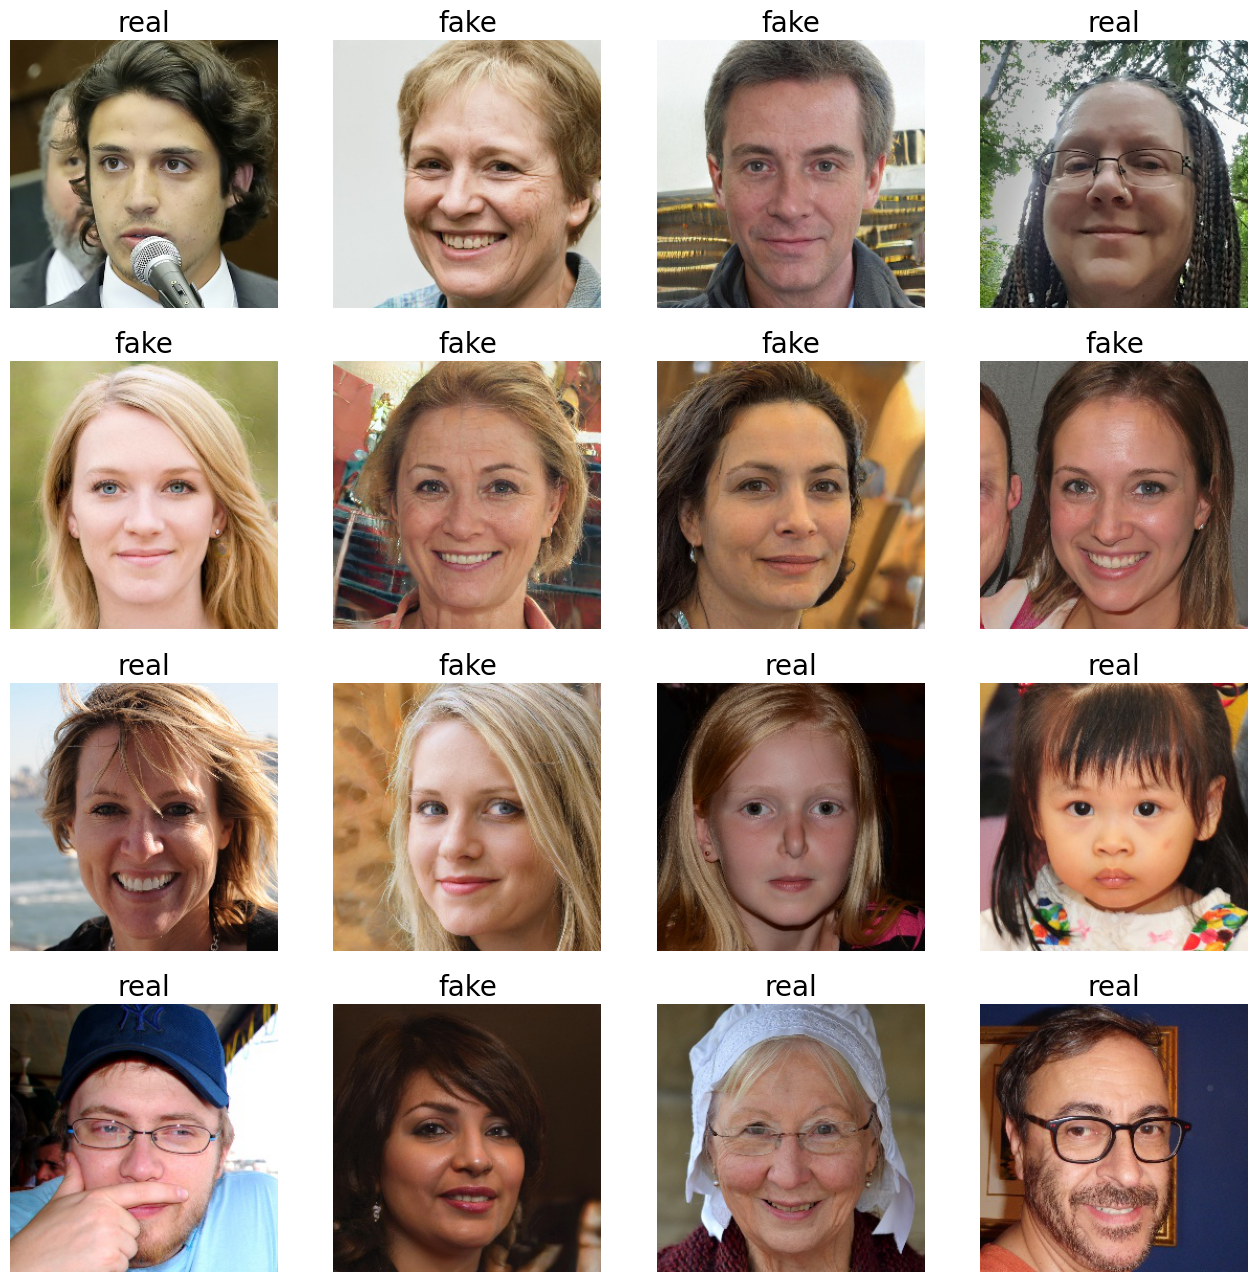

In [59]:
# show raw training data
figure = plt.figure(figsize=(16, 16))
for i in range(16):
    index = indices[i]
    img = raw_dataset[index][0].permute(1, 2, 0)
    label = idx_to_class[raw_dataset[index][1]]
    figure.add_subplot(4, 4, i + 1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img)

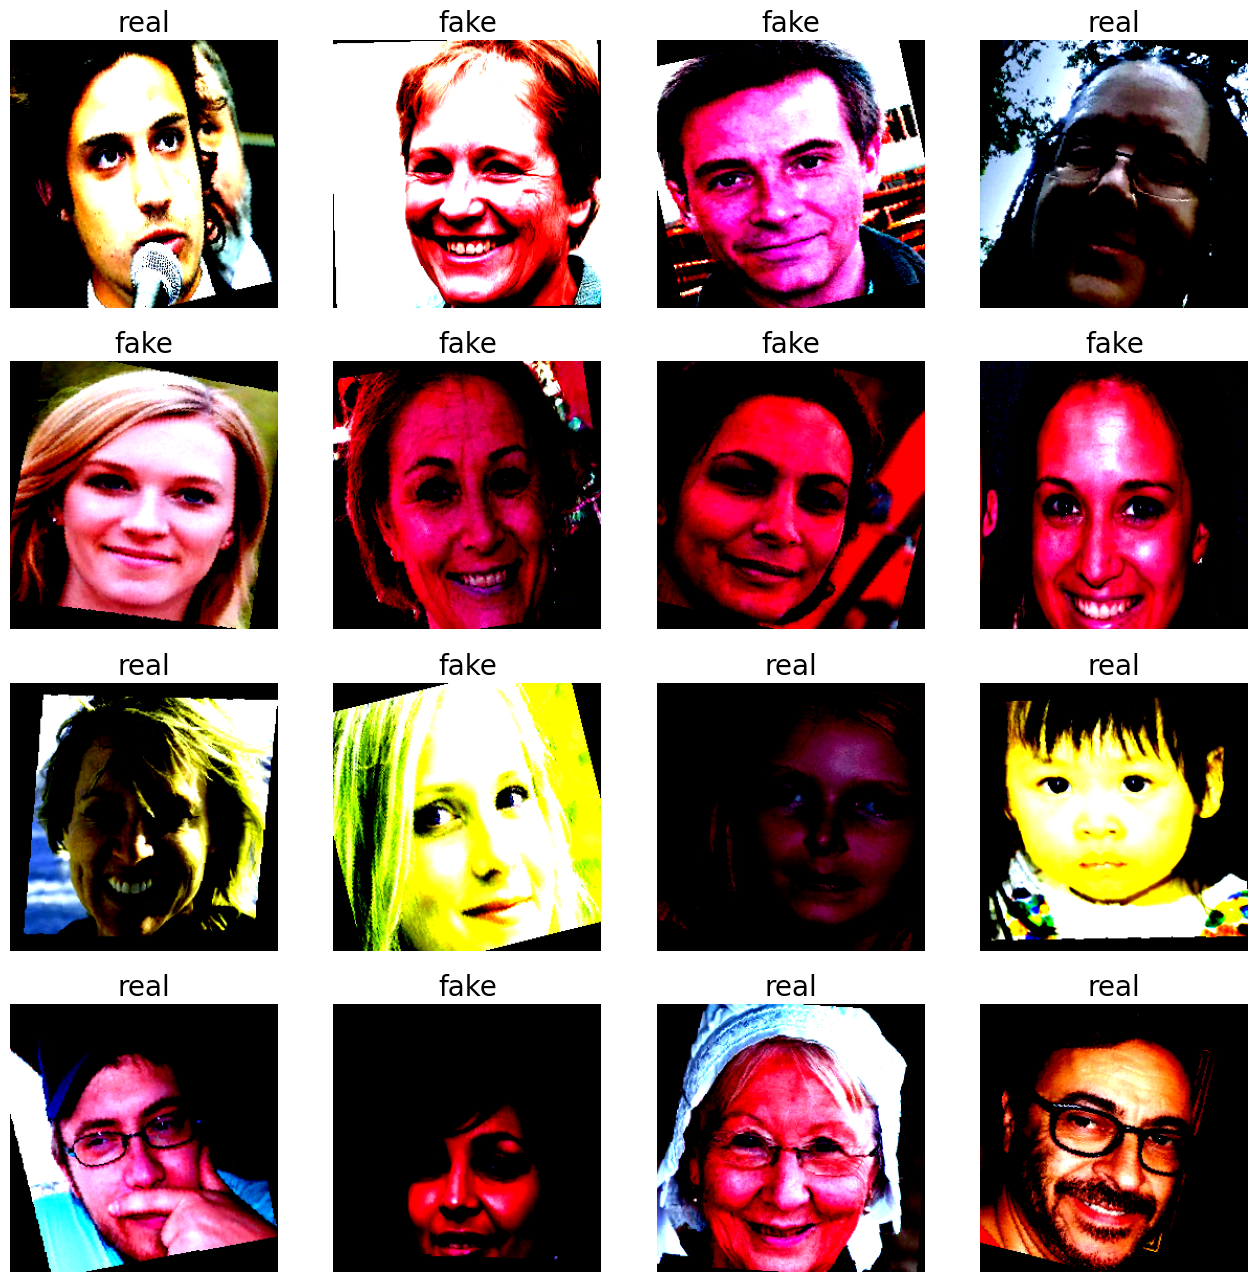

In [60]:
# show augmented training data 
figure = plt.figure(figsize=(16, 16))
for i in range(16):
    index = indices[i]
    img = train_dataset[index][0].permute(1, 2, 0)
    label = idx_to_class[train_dataset[index][1]]
    figure.add_subplot(4, 4, i + 1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img)

# 3. Model

## 3.1 Network

We will use pre-trained swin-transformer V2 model.

In [61]:
# load pretrained model
model = SwinTransformerV2(img_size=args.img_size,
                          drop_path_rate=args.drop_path_rate, 
                          embed_dim=args.embed_dim,
                          depths=args.depths,
                          num_heads=args.num_heads,
                          window_size=args.window_size)
state_dict = torch.load(args.load_model_path)
model.load_state_dict(state_dict["model"])

<All keys matched successfully>

In [62]:
# change the last linear layer to fit our classification problem
model.head = torch.nn.Linear(model.head.in_features, args.num_classes)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
model = model.to(device)

## 3.2 Optimizer

In [65]:
optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate)

In [66]:
if args.scheduler:
    scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                          step_size=args.sch_step_size, 
                                          gamma=args.sch_gamma)

## 3.3 Loss function

In [67]:
loss_fn = torch.nn.CrossEntropyLoss()

# 4. Train

Start training the model and record the intermediate results, including loss, accuracy, precision, recall and f1-score.

In [68]:
train_acc, test_acc = [], []
train_precision, test_precision = [], []
train_recall, test_recall = [], []
train_f1, test_f1 = [], []
train_loss, test_loss = [], []

In [69]:
class LossBuffer:
    """
    We hope to record all losses over a period of time 
    and calculate their average value,
    which is smooth and does not have too much jitter.
    In fact, we don't need to record the entire array, 
    only the current average and number of records are enough.
    """
    
    def __init__(self, mean=0, n=0):
        self.mean = mean
        self.n = n
        
    def add(self, num):
        self.mean = (self.mean * self.n + num) / (self.n + 1)
        self.n += 1

In [70]:
def train(model, dataloader, epoch):
    model.train()
    correct, cursum = 0, 0
    loop = tqdm(dataloader, total=len(dataloader))
    y_true, y_pred = [], []
    loss_buffer = LossBuffer()
    for idx, (data, label) in enumerate(loop):
        data, label = data.to(device), label.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        y_true.extend(label.cpu())
        y_pred.extend(pred.cpu())
        acc = accuracy_score(y_true, y_pred)
        
        optimizer.zero_grad()
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        loss_buffer.add(loss.item())
          
        loop.set_description(f"[Epoch {epoch}/{args.epochs}]")
        loop.set_postfix(LOSS="{:.6f}".format(loss_buffer.mean), ACC="{:.2f}%".format(100 * acc))
    
    if args.scheduler:
        scheduler.step()
        
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    torch.save(model.state_dict(), args.save_model_path)
    
    train_acc.append(acc)
    train_precision.append(precision)
    train_recall.append(recall)
    train_f1.append(f1)
    train_loss.append(loss_buffer.mean)

In [71]:
def test(model, dataloader, epoch):
    model.eval()
    correct = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        total_len = len(dataloader.dataset)
        loss_buffer = LossBuffer()
        for idx, (data, label) in enumerate(dataloader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            y_true.extend(label.cpu())
            y_pred.extend(pred.cpu())
            loss = loss_fn(output, label)
            loss_buffer.add(loss.item())
        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    
    print("\n" + "-" * 60)
    print("[Epoch {}/{}]:  Test -> LOSS: {:.6f}  |  Accuracy: {:.2f}%".format(epoch, args.epochs, loss_buffer.mean, 100 * acc))
    print("-" * 60 + "\n")
    
    test_acc.append(acc)
    test_precision.append(precision)
    test_recall.append(recall)
    test_f1.append(f1)
    test_loss.append(loss_buffer.mean)

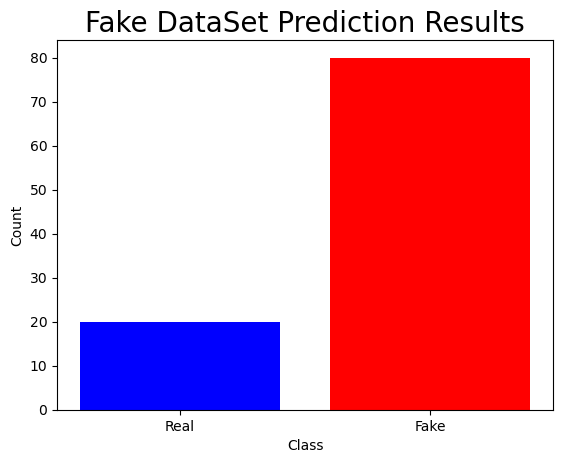

In [72]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Set the path to the directory containing the images you want to predict
prediction_dir = "/kaggle/input/thispersondoesnotexist/thispersondoesnotexist"

# Set the path to the trained model
model_path = "/kaggle/input/swinmodelll/swimtransformernmodel.pth"  # Update with your actual path

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinTransformerV2(img_size=args.img_size,
                          drop_path_rate=args.drop_path_rate, 
                          embed_dim=args.embed_dim,
                          depths=args.depths,
                          num_heads=args.num_heads,
                          window_size=args.window_size,
                          num_classes=args.num_classes)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# Define transformation for prediction images
prediction_transform = transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Initialize counters for real and fake images
real_count = 0
fake_count = 0

# Get a list of image file names in the prediction directory
image_files = [f for f in os.listdir(prediction_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Make predictions for each image and count occurrences
for image_file in image_files:
    image_path = os.path.join(prediction_dir, image_file)
    image = Image.open(image_path).convert("RGB")
    
    # Apply the transformation
    input_tensor = prediction_transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
    
    # Get the predicted class
    predicted_class = torch.argmax(output).item()
    
    # Increment the corresponding counter
    if predicted_class == 0:
        real_count += 1
    elif predicted_class == 1:
        fake_count += 1

# Create a bar graph
classes = ['Real', 'Fake']
counts = [real_count, fake_count]

plt.bar(classes, counts, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Fake DataSet Prediction Results')
plt.show()

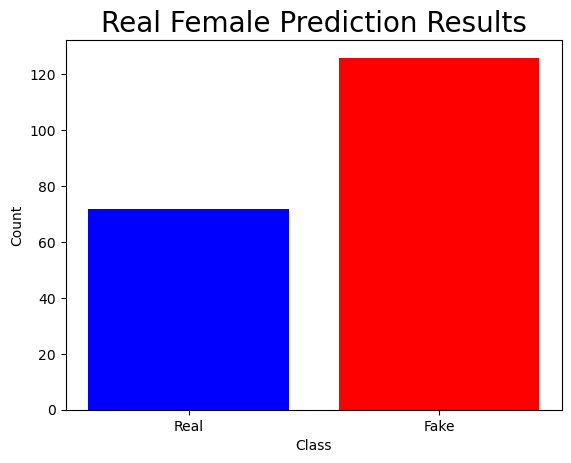

In [73]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Set the path to the directory containing the images you want to predict
prediction_dir = "/kaggle/input/real-dataset-for-deepfake-test/deepfake real dataset/female"

# Set the path to the trained model
model_path = "/kaggle/input/swinmodelll/swimtransformernmodel.pth"  # Update with your actual path

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinTransformerV2(img_size=args.img_size,
                          drop_path_rate=args.drop_path_rate, 
                          embed_dim=args.embed_dim,
                          depths=args.depths,
                          num_heads=args.num_heads,
                          window_size=args.window_size,
                          num_classes=args.num_classes)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# Define transformation for prediction images
prediction_transform = transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Initialize counters for real and fake images
real_count = 0
fake_count = 0

# Get a list of image file names in the prediction directory
image_files = [f for f in os.listdir(prediction_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Make predictions for each image and count occurrences
for image_file in image_files:
    image_path = os.path.join(prediction_dir, image_file)
    image = Image.open(image_path).convert("RGB")
    
    # Apply the transformation
    input_tensor = prediction_transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
    
    # Get the predicted class
    predicted_class = torch.argmax(output).item()
    
    # Increment the corresponding counter
    if predicted_class == 0:
        real_count += 1
    elif predicted_class == 1:
        fake_count += 1

# Create a bar graph
classes = ['Real', 'Fake']
counts = [real_count, fake_count]

plt.bar(classes, counts, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Real Female Prediction Results')
plt.show()

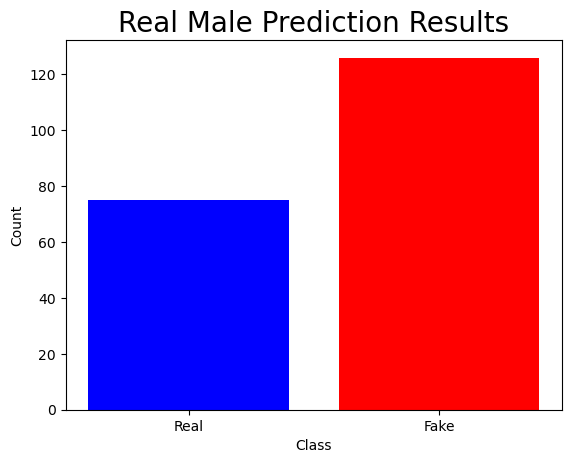

In [74]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Set the path to the directory containing the images you want to predict
prediction_dir = "/kaggle/input/real-dataset-for-deepfake-test/deepfake real dataset/male"

# Set the path to the trained model
model_path = "/kaggle/input/swinmodelll/swimtransformernmodel.pth"  # Update with your actual path

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinTransformerV2(img_size=args.img_size,
                          drop_path_rate=args.drop_path_rate, 
                          embed_dim=args.embed_dim,
                          depths=args.depths,
                          num_heads=args.num_heads,
                          window_size=args.window_size,
                          num_classes=args.num_classes)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# Define transformation for prediction images
prediction_transform = transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Initialize counters for real and fake images
real_count = 0
fake_count = 0

# Get a list of image file names in the prediction directory
image_files = [f for f in os.listdir(prediction_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Make predictions for each image and count occurrences
for image_file in image_files:
    image_path = os.path.join(prediction_dir, image_file)
    image = Image.open(image_path).convert("RGB")
    
    # Apply the transformation
    input_tensor = prediction_transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
    
    # Get the predicted class
    predicted_class = torch.argmax(output).item()
    
    # Increment the corresponding counter
    if predicted_class == 0:
        real_count += 1
    elif predicted_class == 1:
        fake_count += 1

# Create a bar graph
classes = ['Real', 'Fake']
counts = [real_count, fake_count]

plt.bar(classes, counts, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Real Male Prediction Results')
plt.show()

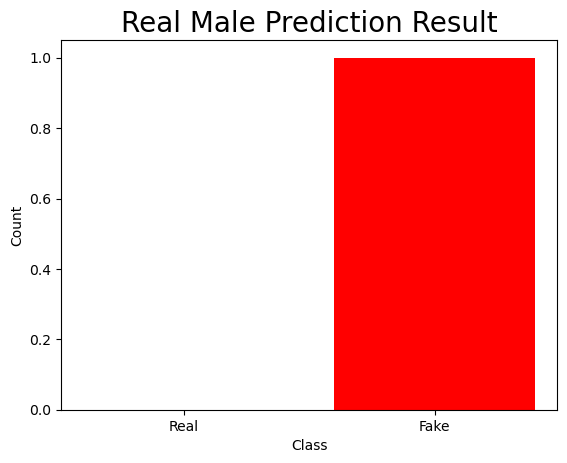

In [76]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Set the path to the trained model
model_path = "/kaggle/input/swinmodelll/swimtransformernmodel.pth"  # Update with your actual path

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinTransformerV2(img_size=args.img_size,
                          drop_path_rate=args.drop_path_rate, 
                          embed_dim=args.embed_dim,
                          depths=args.depths,
                          num_heads=args.num_heads,
                          window_size=args.window_size,
                          num_classes=args.num_classes)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

# Define transformation for prediction images
prediction_transform = transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Set the path to the single image you want to predict
image_path = "/kaggle/input/thispersondoesnotexist/thispersondoesnotexist/person_11.png"  # Update with the correct path

# Load the image
image = Image.open(image_path).convert("RGB")

# Apply the transformation
input_tensor = prediction_transform(image).unsqueeze(0).to(device)

# Make prediction
with torch.no_grad():
    output = model(input_tensor)

# Get the predicted class
predicted_class = torch.argmax(output).item()

# Create a bar graph to visualize the result for the single image
classes = ['Real', 'Fake']
counts = [1 if predicted_class == 0 else 0, 1 if predicted_class == 1 else 0]

plt.bar(classes, counts, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Real Male Prediction Result')
plt.show()
